## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [60]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [5]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [6]:
len(fmnist_dataset_test)

10000

In [7]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [79]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        hidden_dim = 1000
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [67]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1000]         785,000
              ReLU-3                 [-1, 1000]               0
            Linear-4                   [-1, 10]          10,010
Total params: 795,010
Trainable params: 795,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 3.03
Estimated Total Size (MB): 3.06
----------------------------------------------------------------


Your experiments come here:

In [68]:
def plot_accuracy_loss(loss_train, loss_val, acc_train, acc_val):
    clear_output(wait=True)
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
        
    ax[0].set_title("Train and validation loss")
    ax[0].set_xlabel("epoch")
    ax[0].set_ylabel("loss")
    ax[0].plot(loss_train, label='train')
    ax[0].plot(loss_val, label='validation')

    ax[1].set_title("Train and validation accuracy")
    ax[1].set_xlabel("epoch")
    ax[1].set_ylabel("accuracy")
    ax[1].plot(acc_train, label='train')
    ax[1].plot(acc_val, label='validation')

    ax[0].legend()
    ax[1].legend()
    plt.show()

In [69]:
def train(net, optimizer, n_epoch, loss_func):
    loss_history_train = []
    loss_history_validation = []
    accuracy_history_train = []
    accuracy_history_validation = []

    for i in range(n_epoch):
        current_loss_train = []
        current_loss_validation = []
        current_accuracy_train = []
        current_accuracy_validation = []

        net.train()
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()

            # Forward
            predictions = net(x_batch)
            loss = loss_func(predictions, y_batch)

            # Backward
            loss.backward()
            
            # Update weights
            optimizer.step()

            # Remember current loss and accuracy
            current_loss_train.append(loss.detach().cpu().data)
            current_accuracy_train.append((predictions.cpu().detach().numpy().argmax(-1) == 
                                           y_batch.cpu().detach().numpy()).mean())

        net.eval()
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            predictions = net(x_batch)
            loss = loss_func(predictions, y_batch)
            current_loss_validation.append(loss.detach().cpu().data)
            current_accuracy_validation.append((predictions.cpu().detach().numpy().argmax(-1) == 
                                           y_batch.cpu().detach().numpy()).mean())

        # loss/accuracy for epoch is mean value of current losses/accuracies
        loss_history_train.append(sum(current_loss_train)/len(current_loss_train))
        loss_history_validation.append(sum(current_loss_validation)/len(current_loss_validation))
        accuracy_history_train.append(sum(current_accuracy_train)/len(current_accuracy_train))
        accuracy_history_validation.append(sum(current_accuracy_validation)/len(current_accuracy_validation))

        # Visualize
        plot_accuracy_loss(loss_history_train, loss_history_validation, accuracy_history_train, accuracy_history_validation)
        print('Current accuracy: %f' % accuracy_history_validation[-1])
    

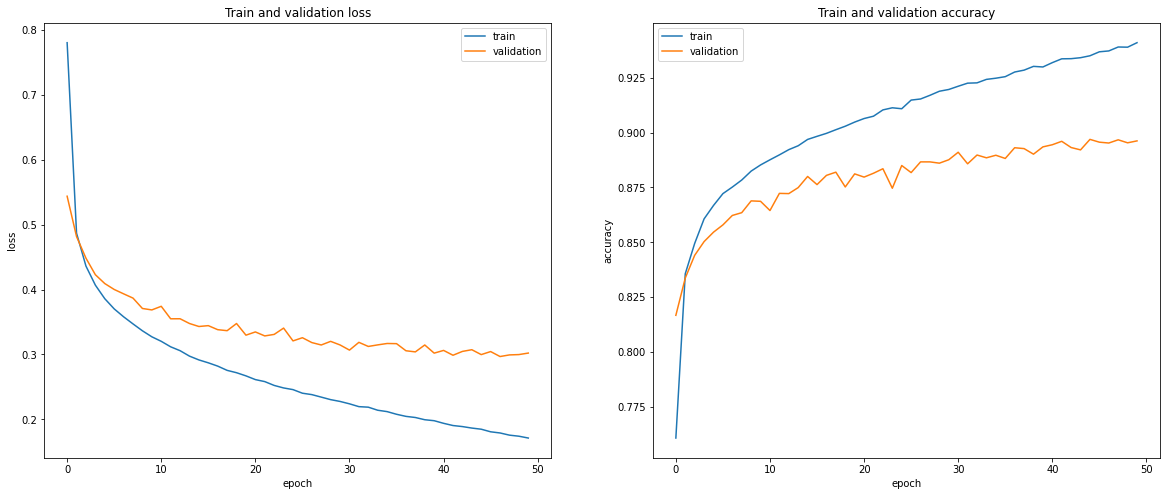

Current accuracy: 0.896191


In [80]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_func = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here
n_epoch = 50
train(model, opt, n_epoch, loss_func)

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [74]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        hidden_dim = 1000
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [75]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1000]         785,000
              ReLU-3                 [-1, 1000]               0
            Linear-4                 [-1, 1000]       1,001,000
              ReLU-5                 [-1, 1000]               0
            Linear-6                 [-1, 1000]       1,001,000
              ReLU-7                 [-1, 1000]               0
            Linear-8                   [-1, 10]          10,010
Total params: 2,797,010
Trainable params: 2,797,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 10.67
Estimated Total Size (MB): 10.72
----------------------------------------------------------------


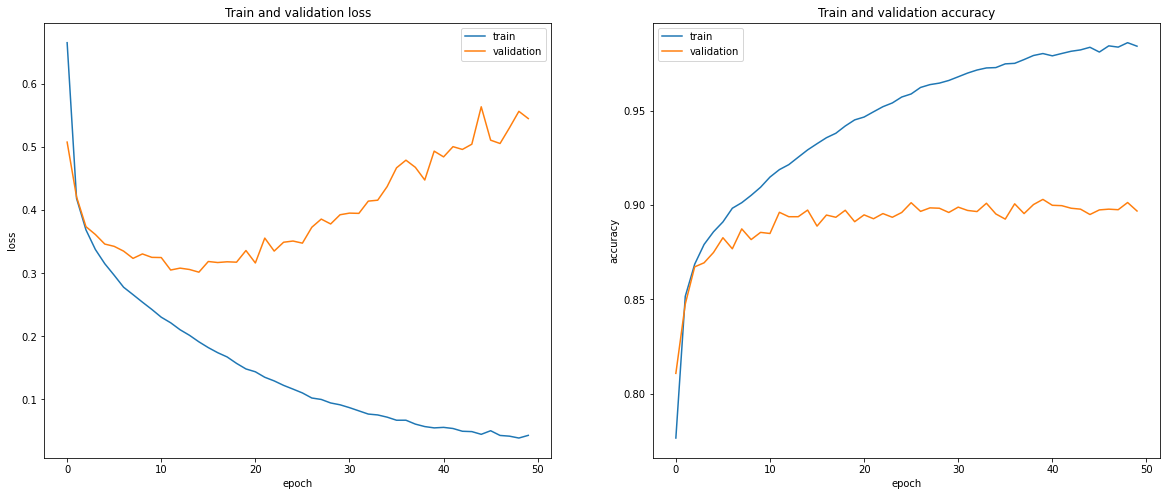

Current accuracy: 0.896777


In [77]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_func = nn.CrossEntropyLoss()

# Your experiments come here
n_epoch = 50
train(model, opt, n_epoch, loss_func)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [91]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        hidden_dim = 1000
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.6),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(hidden_dim, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [92]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1000]         785,000
       BatchNorm1d-3                 [-1, 1000]           2,000
              ReLU-4                 [-1, 1000]               0
           Dropout-5                 [-1, 1000]               0
            Linear-6                 [-1, 1000]       1,001,000
       BatchNorm1d-7                 [-1, 1000]           2,000
              ReLU-8                 [-1, 1000]               0
           Dropout-9                 [-1, 1000]               0
           Linear-10                 [-1, 1000]       1,001,000
      BatchNorm1d-11                 [-1, 1000]           2,000
             ReLU-12                 [-1, 1000]               0
          Dropout-13                 [-1, 1000]               0
           Linear-14                   

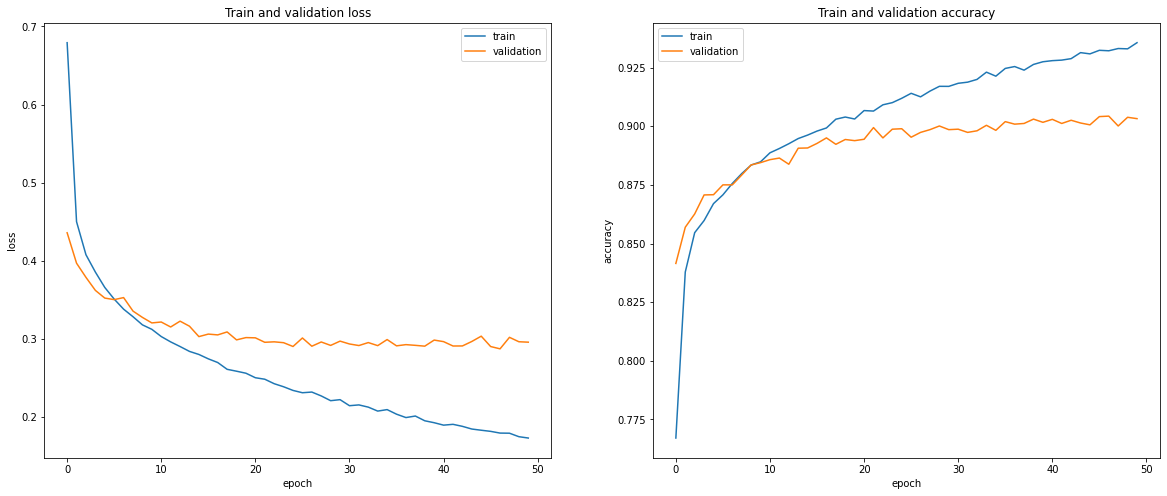

Current accuracy: 0.903223


In [93]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_func = nn.CrossEntropyLoss()

# Your experiments come here
n_epoch = 50
train(model, opt, n_epoch, loss_func)

### Conclusions:
_The more parameters the model has, the more likely it is to find nonexistent dependencies (or the ones found only in train data). So our big model from task 2 classified train data much better than the test one (the loss for the test data was going up from some moment, whereas accuracy was decreasing). To fix it I used batch normalisation and dropout. To see the results I zeroed quite a lot of elements in dropout (so the model was really too big). But it still looks like it starts overfitting with time (loss and accuracy doesn't show progress on the last epoches). However, early stopping is also a regularization technique, so let's use it as well._